**Tasks**

**Convolutional neural network**

You tested above different models with the set of high-level features extracted from a pretrained neural network. However, can you get similar results by (re)training a ConvNet from the pixels?

- What accuracy can you achieve?
- Can you get good results? 
- If not, why?

In [1]:
# filter warnings
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
import tensorflow as tf
from tensorflow import keras
# keras imports
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

import os
import numpy as np
import matplotlib.pyplot as plt
import math

Using TensorFlow backend.


In [2]:
base_dir = os.getcwd()  # Get the current working directory
data_dir = os.path.join(base_dir, 'swissroads')
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
valid_dir = os.path.join(data_dir, 'valid')

In [3]:
GEN_BATCH_SIZE = 128
EPOCHS = 50
IMG_HEIGHT = 256
IMG_WIDTH = 256
NUM_CLASSES = 6
LEARNING_RATE = 1e-4

Overfitting is more likely to occur with a small number of samples and data augmentation seeks to improve this by providing additional data, based on the originals, with random transformations. The goal is the model will never see the exact same picture twice during training. This helps expose the model to more aspects of the data and generalize better.

The ImageDataGenerator transforms and rescale the images before putting them into a revised dataset. Rescaling gives all pixel channes a value from 0 to 255.

Here, I applied rescale, 45 degree rotation, width shift, height shift, horizontal flip and zoom augmentation to the training images.

In [4]:
# apply data augmentation to improve overfitting
train_image_generator = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5,
                    fill_mode='nearest') # Generator for our training data
# only rescale, as we want our model to predict on real world images
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data
test_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our test data

In [5]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=GEN_BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical')

Found 280 images belonging to 6 classes.


In [6]:
valid_data_gen = validation_image_generator.flow_from_directory(batch_size=GEN_BATCH_SIZE,
                                                           directory=valid_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical')

Found 139 images belonging to 6 classes.


In [7]:
test_data_gen = test_image_generator.flow_from_directory(batch_size=GEN_BATCH_SIZE,
                                                           directory=test_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical')

Found 50 images belonging to 6 classes.


In [8]:
sample_training_images, _ = next(train_data_gen)

In [9]:
# Plot images in the form of a grid with 1 row and 5 columns where images are placed in each column to check the data augmentation used.
def plot_images(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

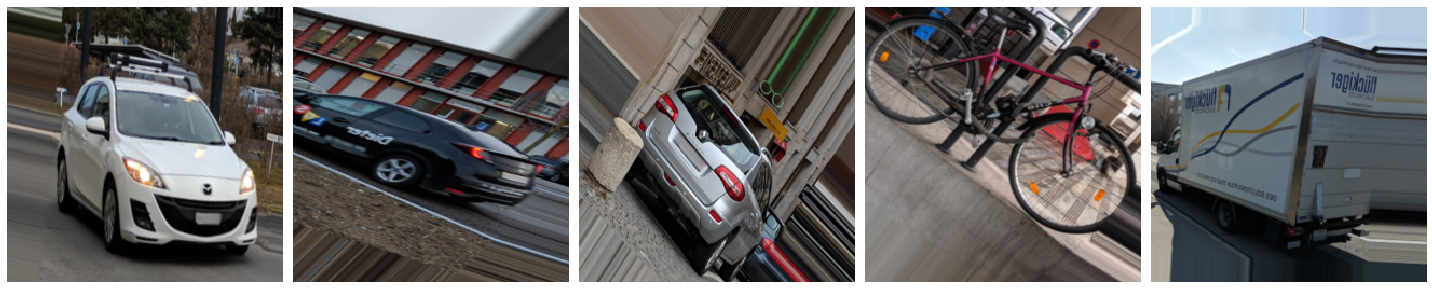

In [10]:
plot_images(sample_training_images[:5])

The architectural decisions we will be making are the number of layers, the number of filters, and the size of the filters. They are quite important and I am quite sure what I am presenting here is suboptimal. Typically the number of layers starts small and grows as the complexity realized by the convoluted layers grows. The number of filters in a layer should be set at ratios of 32, 64, 128, 256, 512 and so on according to one source. In this case I have elected to make four convolutional layers with succeeding filter sizes of 32, 64, 128, and 256. I tried some more complex models with more layers and filters - that actually made things worse.

Filters have odd values since they need to be centered on the pixel being convolved. A 3x3 filter is usual although larger ones of 5x5 up to 7x7 may work better on larger images. Max pool layers typically have a pool size of (2, 2) and are applied after each convolutional layer.

After flattening I chose to set dropout to 0.05. I played with this and set it at values of 0.1, 0.2, 0.4 up to 0.5. It seemed poorly behaved (validation loss jumped all over the place) at higher values.


The model was given a single dense layer with 512 neurons with activation set to 'relu' as usual. The number of layers and neurons in the dense layers are important but I did not tweak the in this example. The number of output elements is always set to the number of classes and activation to 'softmax'.

In [11]:
# build a sequential model
model = Sequential() 
# 1st conv block
model.add(Conv2D(32, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
# 2nd conv block
model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(BatchNormalization())
# 3rd conv block
model.add(Conv2D(128, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(BatchNormalization())
# 4th conv block
model.add(Conv2D(256, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(BatchNormalization())
# Two fully-connected layers on top. 
model.add(Flatten())
model.add(Dropout(0.05))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.1))
# Set output layers to number of classes
model.add(Dense(NUM_CLASSES, activation='softmax'))

In [12]:
model.compile(optimizer=Adam(lr=LEARNING_RATE),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 256)      

In [14]:
# TRAINING_SIZE = 280
 
# VALIDATION_SIZE = 139
 
# # We take the ceiling because we do not drop the remainder of the batch
# compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / MODEL_BATCH_SIZE))
 
# steps_per_epoch = compute_steps_per_epoch(TRAINING_SIZE)
# val_steps = compute_steps_per_epoch(VALIDATION_SIZE)
MODEL_BATCH_SIZE = 32

In [15]:
# cb = TqdmCallback()
# setattr(cb,'on_train_batch_begin',lambda x,y:None)
# setattr(cb,'on_train_batch_end',lambda x,y:None)

In [16]:
cnn = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(MODEL_BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=valid_data_gen,
    validation_steps=int(np.ceil(valid_data_gen.n / float(MODEL_BATCH_SIZE))),
#     use_multiprocessing=False,
#     verbose=2
)

Epoch 1/50
9/9 [==============================] - 114s 13s/step - loss: 1.7484 - accuracy: 0.2524 - val_loss: 1.7235 - val_accuracy: 0.2857
Epoch 2/50
9/9 [==============================] - 100s 11s/step - loss: 1.7253 - accuracy: 0.3060 - val_loss: 1.7534 - val_accuracy: 0.3841
Epoch 3/50
9/9 [==============================] - 113s 13s/step - loss: 1.6704 - accuracy: 0.3202 - val_loss: 1.6604 - val_accuracy: 0.3054
Epoch 4/50
9/9 [==============================] - 99s 11s/step - loss: 1.6178 - accuracy: 0.3762 - val_loss: 1.5010 - val_accuracy: 0.4498
Epoch 5/50
9/9 [==============================] - 104s 12s/step - loss: 1.5870 - accuracy: 0.3738 - val_loss: 1.5288 - val_accuracy: 0.4286
Epoch 6/50
9/9 [==============================] - 99s 11s/step - loss: 1.5489 - accuracy: 0.3869 - val_loss: 1.3474 - val_accuracy: 0.4394
Epoch 7/50
9/9 [==============================] - 109s 12s/step - loss: 1.5068 - accuracy: 0.4095 - val_loss: 1.4143 - val_accuracy: 0.4286
Epoch 8/50
9/9 [======

**Notes:**

I initially trained the model for 15 epochs, batch size of 64, and standard parameters. Even though it is a deep architecture, I could only get a validation accuracy of around 30%.

Tried the following steps in order to improve accuracy:

- Applied different data augmentation techniques (rescale, 45 degree rotation, width shift, height shift, horizontal flip and zoom augmentation).  
- Applied a dropout with different probability (of up to 50%, which means that up to 50% (randomly chosen) of the values coming into the dropout layers will be set to zero). Higher dropout rates seemed poorly behaved (validation loss jumped all over the place) at higher values.
- Finally I reduced the learning rate by factors of 10 and retried. Learning rate is a hyper-parameter that controls how much we are adjusting the weights of our network with respect the loss gradient. The lower the value, the slower we travel along the downward slope. While this might be a good idea (using a low learning rate) in terms of making sure that we do not miss any local minima, it could also mean that we’ll be taking a long time to converge — especially if we get stuck on a plateau region. A smaller learning rate of 1e-4 improved the validation accuracy to approximately 47%. An even smaller learning rate of 1e-5 lead to a validation accuracy of approximately 40%. Perhaps given a big enough number of epochs the validation accuracy might improve further, but as it was, it seemed to get stuck in local minima.

At this point I decided to keep the learning rate at 1e-4 and droput rate at 0.05 and try the following:

- Increased the number of epochs to 50 which lead to a validation accuracy of 60%.
- Kept the number of epochs at 50 and reduced the batch size to 32, which lead to a validation accuracy close to 65%.
- Increased the number of epochs to 100 and kept the batch size at 32, but the model started to overfit after 50 epochs. Given that for this trial it took a couple of hours to finish training, I decided not to investigate any further, and left it here at 50 epochs with a validation accuracy of 65%.

Still the validation accuracy is not as high as for the other models, which used high-level features extracted from a pretrained neural network.

There can be many reasons for this, such as the model is not complex enough to learn the underlying patterns of images, but most probably this is due to the fact that the training data is too small to accurately generalize across classes.

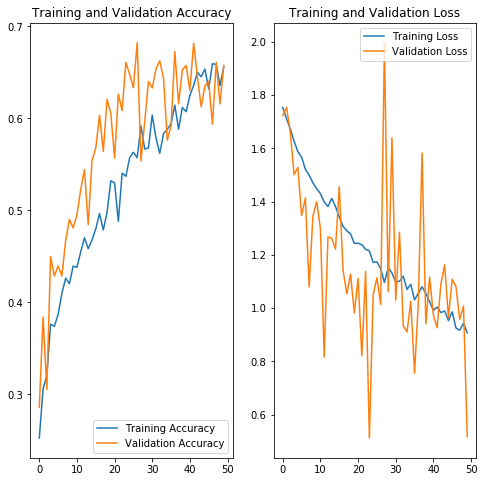

In [17]:
acc = cnn.history['accuracy']
val_acc = cnn.history['val_accuracy']

loss = cnn.history['loss']
val_loss = cnn.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The training dataset seems ok behaved and steadily climbs to about 65% accuracy at 50 epochs. The validation accuracy is pretty jagged (maybe due to such a small dataset?) but tracks the training set and also peaks around approximately 65% and epoch 50. 

In [19]:
# evaluate model on validation data
_, acc = model.evaluate_generator(valid_data_gen, steps=len(valid_data_gen), verbose=0)
print('CNN accuracy on validation data: %.3f' % (acc))

CNN accuracy on validation data: 0.655


In [18]:
# evaluate model on test data
_, acc = model.evaluate_generator(test_data_gen, steps=len(test_data_gen), verbose=0)
print('CNN accuracy on test data: %.3f' % (acc))

CNN accuracy on test data: 0.520
